In [1]:
from motor.motor_asyncio import AsyncIOMotorClient

mongo = AsyncIOMotorClient('127.0.0.1', 27017)

In [165]:
pipeline = [ {'$group': {'_id': '$user_id', 'count': {'$sum': 1}}} ]
result = await mongo.gg.messages.aggregate(pipeline).to_list(length=None)
result = sorted(result, key=lambda x: x['count'], reverse=True)
users_with_messages = {row['_id'] for row in result if row['count'] > 0}
users_messages = {row['_id']: row['count'] for row in result}

pipeline = [ {'$group': {'_id': '$user_id', 'count': {'$sum': 1}}} ]
result = await mongo.gg.users.aggregate(pipeline).to_list(length=None)
all_users_in_chat = {row['_id'] for row in result if row['count'] > 0}

print('Total users in chat:', len(all_users_in_chat))
print('Users with messages:', len(users_with_messages), '({:.2f}%)'.format(100 * len(users_with_messages) / len(all_users_in_chat)))

Total users in chat: 4962
Users with messages: 1730 (34.86%)


In [2]:
users_data = {}

start_from = 1693073240

all_users = await mongo.gg.users.aggregate(
    [
        {'$match': {'timestamp': {'$gt': start_from}}},
        {'$group': {'_id': '$user_id', 'count': {'$sum': 1}}},
    ]
).to_list(length=None)  # type: ignore
all_users = [row['_id'] for row in all_users]

for i, user_id in enumerate(all_users):
    if i % 1000 == 0:
        print(f'{i+1:5} / {len(all_users)}')
    total_time = 0
    last_time = 0
    result_users = await mongo.gg.users.find(
        {'user_id': user_id, 'timestamp': {'$gt': start_from}}
    ).to_list(length=None)  # type: ignore

    # add messages time
    result_messages = await mongo.gg.messages.find(
        {'user_id': user_id, 'timestamp': {'$gt': start_from}}
    ).to_list(length=None)  # type: ignore
    for row in result_messages:
        result_users.append({'timestamp': row['timestamp']})

    result_users = sorted(result_users, key=lambda x: x['timestamp'], reverse=False)
    if not result_users:
        continue

    for row in result_users:
        delta = row['timestamp'] - last_time
        if delta < 60 * 15:
            total_time += delta / 60
        last_time = row['timestamp']
    messages = len(result_messages)
    users_data[user_id] = {'total_time': total_time, 'messages': messages}

print('done')

    1 / 4132
 1001 / 4132
 2001 / 4132
 3001 / 4132
 4001 / 4132
done


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

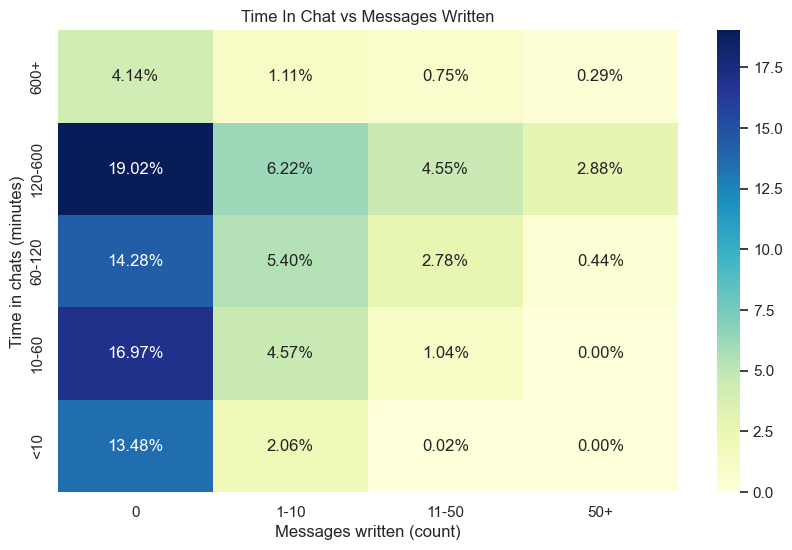

In [4]:
df = pd.DataFrame([{'_id': user_id, **data} for user_id, data in users_data.items()])

def categorize_time(total_time):
    if total_time < 10:
        return "<10"
    elif 10 <= total_time < 60:
        return "10-60"
    elif 60 <= total_time < 120:
        return "60-120"
    elif 120 <= total_time < 600:
        return "120-600"
    else:
        return "600+"

def categorize_messages(messages_count):
    if messages_count == 0:
        return "0"
    elif 1 <= messages_count <= 10:
        return "1-10"
    elif 11 <= messages_count <= 50:
        return "11-50"
    else:
        return "50+"

df['time_range'] = df['total_time'].apply(categorize_time)
df['messages_range'] = df['messages'].apply(categorize_messages)

# Create categorical columns with specified order
time_range_order = ["<10", "10-60", "60-120", "120-600", "600+"][::-1]
messages_range_order = ["0", "1-10", '11-50', "50+"]
df['time_range'] = pd.Categorical(df['time_range'], categories=time_range_order, ordered=True)
df['messages_range'] = pd.Categorical(df['messages_range'], categories=messages_range_order, ordered=True)

sns.set(style="whitegrid")
# Create a pivot table for plotting
pivot_df = df.pivot_table(
    index='time_range', 
    columns='messages_range', 
    values='_id', 
    aggfunc='count', 
    fill_value=0,
)

# Calculate total count for percentage calculation
total_count = pivot_df.values.sum()
# Calculate percentages and format annotations
pivot_df_percentages = pivot_df / total_count * 100
annot_df = pivot_df_percentages.applymap(lambda x: f"{x:.2f}%")

# Create the heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df_percentages, annot=annot_df, fmt="", cmap="YlGnBu")
# sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Time In Chat vs Messages Written')
plt.xlabel('Messages written (count)')
plt.ylabel('Time in chats (minutes)')
plt.show()

In [5]:
df[(df['messages_range'] == '11-50') & (df['time_range'] == '<10')]

,_id,total_time,messages,time_range,messages_range
833,1324013,9.683333,34,<10,11-50
